In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from statistics import median

In [2]:
train_data = pd.read_pickle('prepro_v1.1/train_data.p')
train_shared = pd.read_pickle('prepro_v1.1/train_shared.p')

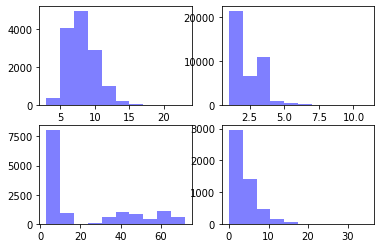

In [75]:
# determine thresholds q_thres, cs_thres, ps_thres, pts_thes
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

q_lens = [len(q) for q in train_data['q']]
axs[0, 0].hist(q_lens, 10, facecolor='blue', alpha=0.5)

cs_lens = [len(c) for cs in train_data['cs'] for c in cs]
axs[0,1].hist(cs_lens, 10, facecolor='blue', alpha=0.5)

photos_lens = [sum(len(train_shared['albums'][aid]['photo_titles']) for aid in aid_list) for aid_list in train_data['aid']]
axs[1,0].hist(photos_lens, 10, facecolor='blue', alpha=0.5)

pts_lens = [len(pt) for aid in train_shared['albums'] for pt in train_shared['albums'][aid]['photo_titles']]
axs[1,1].hist(pts_lens, 10, facecolor='blue', alpha=0.5)

plt.show()

In [129]:
Q_THRES = int(median(q_lens))  # 8
CS_THRES = int(median(cs_lens))  # 1
PS_THRES = int(median(photos_lens)) # 9
PTS_THRES = int(median(pts_lens)) # 3
PTS_TOTAL_THRES = PTS_THRES * PS_THRES # 27

In [202]:
class MemexQA(Dataset):
    def __init__(self, data, shared):
        self.data = data
        self.shared = shared
    
    def __len__(self):
        return len(self.data['q'])
    
    def __getitem__(self, idx):
        returned_item = {}
        
        # question glove
        q = self.data['q'][idx]
        q_vec = torch.FloatTensor([self.shared['word2vec'][word.lower()] for word in q if word.lower() in self.shared['word2vec']])
        if len(q_vec) < Q_THRES:
            q_vec = F.pad(q_vec, (0, 0, 0, Q_THRES - len(q_vec)))
        else:
            q_vec = q_vec[:Q_THRES]
        returned_item['q_vec'] = q_vec  # shape (8, 100)
        
        # choices glove
        wrong_cs = self.data['cs'][idx]
        correct_c = self.data['y'][idx]
        yidx = self.data['yidx'][idx]
        if yidx == 0:
            cs = [correct_c] + wrong_cs
        elif yidx == 1:
            cs = wrong_cs[:1] + [correct_c] + wrong_cs[1:]
        elif yidx == 2:
            cs = wrong_cs[:2] + [correct_c] + wrong_cs[2:]
        else:  # yidx == 3
            cs = wrong_cs + [correct_c]
        cs_vec = torch.FloatTensor()
        for c in cs:
            c_vec = torch.FloatTensor([self.shared['word2vec'][word.lower()] for word in c if word.lower() in self.shared['word2vec']])
            if c_vec.nelement() == 0:
                c_vec = torch.zeros((CS_THRES, 100))
            elif len(c_vec) < CS_THRES:
                c_vec = F.pad(c_vec, (0, 0, 0, CS_THRES - len(c_vec)))
            else:
                c_vec = c_vec[:CS_THRES]
            cs_vec = torch.cat((cs_vec, c_vec))
        returned_item['cs_vec'] = torch.unsqueeze(cs_vec, 1)  # since CS_THRES = 1 => shape (4, 1, 100)
        
        # Caveat #1: photos belong to multiple albums
        # Caveat #2: currently concat all words
        aid_list = self.data['aid'][idx]
        # photo titles glove
        pts = [pt for aid in aid_list for pt in self.shared['albums'][aid]['photo_titles']]
        pts_vec = torch.FloatTensor()
        for pt in pts:
            pt_vec = torch.FloatTensor([self.shared['word2vec'][word.lower()] for word in pt if word.lower() in self.shared['word2vec']])
            pts_vec = torch.cat((pts_vec, pt_vec))
        if pts_vec.nelement() == 0:
            pts_vec = torch.zeros((PTS_TOTAL_THRES, 100))
        elif len(pts_vec) < PTS_TOTAL_THRES:
            pts_vec = F.pad(pts_vec, (0, 0, 0, PTS_TOTAL_THRES - len(pts_vec)))
        else:
            pts_vec = pts_vec[:PTS_TOTAL_THRES]
        returned_item['pts_vec'] = pts_vec
        
        # image features of photos
        pid_list = [pid for aid in aid_list for pid in self.shared['albums'][aid]['photo_ids']]
        img_feats = torch.FloatTensor([self.shared['pid2feat'][pid] for pid in pid_list])
        if len(pid_list) < PS_THRES:
            img_feats = F.pad(img_feats, (0, 0, 0, PS_THRES - len(pid_list)))
        else:
            img_feats = img_feats[:PS_THRES]
        returned_item['img_feats'] = img_feats
        
        return returned_item, yidx

In [203]:
data = MemexQA(train_data, train_shared)

In [204]:
for i in range(len(data)):
    X, y = data[i]
    assert X['q_vec'].shape == (8, 100), X['q_vec'].shape
    assert X['cs_vec'].shape == (4, 1, 100)
    assert X['pts_vec'].shape == (27, 100)
    assert X['img_feats'].shape == (9, 2537)

In [200]:
train_data['q'][529]

['How', 'many', 'people', 'were', 'wearing', 'blue', 'crowns+', '?']

In [162]:
print(photos_lens)

[9, 65, 9, 8, 8, 8, 8, 8, 8, 65, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 65, 8, 8, 8, 8, 8, 8, 65, 8, 8, 8, 6, 6, 65, 6, 6, 6, 65, 65, 65, 65, 65, 65, 65, 65, 65, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 45, 45, 45, 45, 45, 45, 45, 45, 7, 7, 7, 7, 8, 8, 8, 7, 7, 7, 37, 7, 8, 8, 8, 37, 8, 7, 37, 7, 37, 7, 37, 37, 37, 37, 37, 8, 8, 8, 10, 10, 10, 41, 7, 10, 10, 41, 6, 6, 6, 41, 41, 41, 41, 41, 41, 41, 41, 41, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 42, 42, 42, 42, 42, 6, 6, 9, 49, 9, 10, 10, 7, 49, 7, 7, 8, 8, 8, 8, 9, 9, 9, 49, 49, 49, 49, 49, 49, 10, 7, 7, 9, 9, 9, 7, 7, 9, 9, 9, 42, 42, 42, 42, 42, 42, 42, 42, 42, 8, 8, 8, 7, 7, 8, 41, 8, 41, 9, 9, 9, 9, 41, 9, 9, 9, 41, 41, 41, 41, 41, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 68, 68, 68, 68, 68, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 6, 6, 9, 9, 8, 8, 8, 62, 62, 62, 62, 62, 62, 9, 9, 7, 7, 7, 7, 39, 7, 8, 8, 8, 8, 8, 39, 39, 39, 39, 39, 39, 39, 39, 7, 65, 7, 7, 7, 9, 9, 9, 9, 9, 8, 8, 8, 